In [27]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')


from __init__ import *
import seaborn as sns 
from scipy.stats import zscore
import matplotlib.pyplot as plt
from natsort import natsorted
import functools
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import gaussian_kde
import collections
# import tables
import itertools
import re
import umap
import fbpca


import snmcseq_utils
importlib.reload(snmcseq_utils)
from snmcseq_utils import get_mcc
from snmcseq_utils import logcpm 
from snmcseq_utils import logtpm
from snmcseq_utils import gene_id_to_name 
from snmcseq_utils import gene_name_to_id 

# import CEMBA_update_mysql
import CEMBA_run_tsne
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)



<module 'CEMBA_clst_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/CEMBA_clst_utils.py'>

In [28]:
name = 'debug_mop_0915'
outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)
output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)

SAVE_KNN_MAT = True
output_knn_mat = outdir + '/knn_{}_{{}}_from_{{}}.npz'.format(name)

In [29]:
sys.path.insert(0, '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons')
import __init__datasets
import __init__jupyterlab

importlib.reload(__init__datasets)
from __init__datasets import *
from __init__jupyterlab import *

In [30]:
log = snmcseq_utils.create_logger()
logging.info('*')

09/16/2019 02:22:43 PM *


In [31]:
def standardize_gene_name(gene_name):
    new_name = gene_name[0].upper() + gene_name[1:].lower()
    
    return new_name

standardize_gene_name = np.vectorize(standardize_gene_name)

## Basic setups
- metadata
- feature (highly variable) matrix

In [32]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons'
mods_selected = [
    'snmcseq_gene',
#     'snatac_gene',
    'smarter_cells',
    'smarter_nuclei',
    '10x_cells_v2', 
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     '10x_nuclei_v3_macosko',
    ]

features_selected = mods_selected.copy() 
features_selected = ['10x_cells_v2']
# features_selected = ['smarter_cells']

mods_selected


['snmcseq_gene', 'smarter_cells', 'smarter_nuclei', '10x_cells_v2']

In [33]:
# within modality
ps = {'mc': 0.9,
      'atac': 0.1,
      'rna': 0.7,
     }

drop_npcs = {'mc': 0,
      'atac': 0,
      'rna': 0,
     }
# across modality
KNN = 20 
RELAXATION = 3 

# PCA
npc = 50

# clustering
k = 30
resolutions = [1, 2, 4, 8]
# umap
umap_neighbors = 60
min_dist=min_dist = 0.5

In [34]:
meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
metas = collections.OrderedDict()

for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    
    print(metas[mod].iloc[:1, :2], len(metas[mod]))

                     index  leiden
cell                              
snmcseq_gene_2C_M_0      0       1 9286
                                  index  cluster_id
cell                                               
smarter_cells_LS-15395_S41_E1-50      0          19 6244


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                                    index  cluster_id
cell                                                 
smarter_nuclei_SM-GE653_S113_E1-50      0           2 5911
                                                   index  cluster_id
cell                                                                
10x_cells_v2_AAACCTGAGGAGTCTG-1L8TX_171026_01_F03      0           9 121440


In [35]:
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

gxc_hvftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        f_mat = hvftrs_f.format(mod, 'tsv')
        gxc_hvftrs[mod] = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
        gxc_hvftrs[mod].index = standardize_gene_name(gxc_hvftrs[mod].index)  # standardize gene name 
        print(gxc_hvftrs[mod].shape, time.time()-ti)
        assert np.all(gxc_hvftrs[mod].columns.values == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
        continue
        
        
    f_mat = hvftrs_f.format(mod, 'npz')
    f_gene = hvftrs_gene.format(mod)
    f_cell = hvftrs_cell.format(mod)
    
    _mat = sparse.load_npz(f_mat) 
    _gene = pd.read_csv(f_gene, sep='\t', header=None).iloc[:, 0].values
    _gene = standardize_gene_name(_gene)  # standardize gene name  
    _cell = pd.read_csv(f_cell, sep='\t', header=None).iloc[:, 0].values 
    
    ## remove duplicated genes (for now)
    u, c = np.unique(_gene, return_counts=True)
    dup = u[c > 1]
    uniq_bool = np.array([False if gene in dup else True for gene in _gene])
    _gene_selected = _gene[uniq_bool]
    _gene_selected_idx = np.arange(len(_gene))[uniq_bool]
    _gene = _gene_selected
    _mat = _mat.tocsr()[_gene_selected_idx, :]
    ## remove duplicated genes complete
    
    gxc_hvftrs[mod] = GC_matrix(_gene, _cell, _mat)
    assert np.all(gxc_hvftrs[mod].cell == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
    print(gxc_hvftrs[mod].data.shape, time.time()-ti)
    

snmcseq_gene
(4877, 9286) 21.934410572052002
smarter_cells
(5743, 6244) 1.426422357559204
smarter_nuclei
(5400, 5911) 0.7913002967834473
10x_cells_v2
(4067, 121440) 15.72052526473999


## smooth within modality

In [36]:
# smooth-within modality
def smooth_in_modality(counts_matrix, norm_counts_matrix, k, ka, npc=100, sigma=1.0, p=0.1, drop_npc=0):
    """Smooth a data matrix
    
    Arguments:
        - counts_matrix (pandas dataframe, feature by cell)
        - norm_counts_matrix (pandas dataframe, feature by cell) log10(CPM+1)
        - k (number of nearest neighbors)
    Return:
        - smoothed cells_matrix (pandas dataframe)
        - markov affinity matrix
    """
    from sklearn.neighbors import NearestNeighbors
    import fbpca
    import CEMBA_clst_utils
    
    assert counts_matrix.shape[1] == norm_counts_matrix.shape[1] 

    c = norm_counts_matrix.columns.values
    N = len(c)

    # reduce dimension fast version
    U, s, Vt = fbpca.pca(norm_counts_matrix.T.values, k=npc)
    pcs = U.dot(np.diag(s))
    if drop_npc != 0:
        pcs = pcs[:, drop_npc:]

    # get k nearest neighbor distances fast version 
    inds, dists = CEMBA_clst_utils.gen_knn_annoy(pcs, k, form='list', 
                                                metric='euclidean', n_trees=10, search_k=-1, verbose=True, 
                                                include_distances=True)
    
    # remove itself
    dists = dists[:, 1:]
    inds = inds[:, 1:]

    # normalize by ka's distance 
    dists = (dists/(dists[:, ka].reshape(-1, 1)))

    # gaussian kernel
    adjs = np.exp(-((dists**2)/(sigma**2))) 

    # construct a sparse matrix 
    cols = np.ravel(inds)
    rows = np.repeat(np.arange(N), k-1) # remove itself
    vals = np.ravel(adjs)
    A = sparse.csr_matrix((vals, (rows, cols)), shape=(N, N))

    # Symmetrize A (union of connection)
    A = A + A.T

    # normalization fast (A is now a weight matrix excluding itself)
    degrees = A.sum(axis=1)
    A = sparse.diags(1.0/np.ravel(degrees)).dot(A)

    # include itself
    eye = sparse.identity(N)
    A = p*eye + (1-p)*A
    
    # smooth fast (future?)
    counts_matrix_smoothed = pd.DataFrame((A.dot(counts_matrix.T)).T, 
                                         columns=counts_matrix.columns, index=counts_matrix.index)
    return counts_matrix_smoothed, A


In [37]:

# GENE * CELL !!!!
smoothed_features = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        _df = gxc_hvftrs[mod]
    else:
        _mat = gxc_hvftrs[mod].data.todense()
        _df = pd.DataFrame(_mat, 
                          index=gxc_hvftrs[mod].gene, 
                          columns=gxc_hvftrs[mod].cell, 
                          ) 
        
    mat_smoothed, mat_knn = smooth_in_modality(_df, _df, k=30, ka=5, npc=50, p=ps[settings[mod].mod_category], drop_npc=drop_npcs[settings[mod].mod_category])
    smoothed_features[mod] = mat_smoothed
    print(smoothed_features[mod].shape)
    print(time.time() - ti)
    


snmcseq_gene
Time used to build kNN map 0.18627309799194336
Time used to get kNN 0.35857272148132324
(4877, 9286)
2.5993423461914062
smarter_cells
Time used to build kNN map 0.13220953941345215
Time used to get kNN 0.2161085605621338
(5743, 6244)
2.282853841781616
smarter_nuclei
Time used to build kNN map 0.12630033493041992
Time used to get kNN 0.21522116661071777
(5400, 5911)
2.1950392723083496
10x_cells_v2
Time used to build kNN map 2.187286376953125
Time used to get kNN 6.126214981079102
(4067, 121440)
40.48663020133972


## Impute across

- get all pairs of modalities
- get common genes
- get MNN across mod using correlations of cells across common genes (MNN)
- get kNN within mod
- Use the above 2 to impute across modality

In [13]:
def get_constrained_knn(mat_norm_j, mat_norm_i, knn, k_saturate, knn_speed_factor=10, metric='dot'):
    """Get constrained knn
    j <- i
    Look for kNN in i for each cell in j, cells in i are constrained to k_saturated
    
    get knn_speed_factor*knn number of nearest neighbors internally
    """
    ti = time.time()
    assert mat_norm_i.shape[1] == mat_norm_j.shape[1]
    knn = int(knn)
    knn_speed_factor = int(knn_speed_factor)
    
    cells_i = np.arange(len(mat_norm_i))
    cells_j = np.arange(len(mat_norm_j))
    
    # record cells in j
    accepted_knn_ji = [] 
    accepted_cells = []
    rejected_cells = np.arange(len(cells_j))
    
    # record cell in i
    n_connects = np.zeros(len(cells_i)).astype(int) # record number of connection for each cell in i 
    unsaturated = (n_connects < k_saturate) # unsaturated bool 
    unsaturated_cells = np.arange(len(cells_i))[unsaturated]
    
    while rejected_cells.size != 0:
        print(len(rejected_cells), len(unsaturated_cells), time.time()-ti)
        
        np.random.shuffle(rejected_cells) # random order
        # do something to rejected cells and unsaturated cells
        # knn_ji # for each cell in j, its knn in i
        knn_ji = CEMBA_clst_utils.gen_knn_annoy_train_test(mat_norm_i.values[unsaturated_cells], # look for nearest neighbors in i 
                                                           mat_norm_j.values[rejected_cells], # for each row in j
                                                           min(knn*knn_speed_factor, len(unsaturated_cells)), #  
                                                           form='list', # adj matrix 
                                                           metric=metric, # correlation 
                                                           n_trees=10, search_k=-1, verbose=False, 
                                                           include_distances=False, # for now
                                                           ).astype(int)
        knn_ji = unsaturated_cells[knn_ji] # transform it to global index, need to check this like 
        
        rejected_local_idx = []
        # examine each cell in j
        for local_idx, cell in enumerate(rejected_cells):
            # get knn in i
            knn_in_i = knn_ji[local_idx]
            # filter out saturated ones
            knn_in_i = knn_in_i[unsaturated[knn_in_i]]
            
            if knn_in_i.size < knn:
                # reject
                rejected_local_idx.append(local_idx)
            else:
                # accept and update
                accepted_knn_ji.append(knn_in_i[:knn])
                accepted_cells.append(cell)
                n_connects[knn_in_i[:knn]] += 1 
                unsaturated = (n_connects < k_saturate) # unsaturated bool 
                
        unsaturated_cells = np.arange(len(cells_i))[unsaturated]
        rejected_cells = rejected_cells[rejected_local_idx]
#         break
                
    accepted_knn_ji = pd.DataFrame(np.vstack(accepted_knn_ji), index=accepted_cells)
    accepted_knn_ji = accepted_knn_ji.sort_index().values
    
    return accepted_knn_ji
    

In [14]:
def sparse_adj_to_mat(adjs, row_size, col_size, dists=''):
    """Turn a knn adjacency matrix to a sparse matrix
    """
    n_obs, k = adjs.shape
    assert n_obs == row_size
    # row col 1/dist 
    row_inds = np.repeat(np.arange(row_size), k)
    col_inds = np.ravel(adjs)
    if isinstance(dists, np.ndarray):
        assert dists.shape == adjs.shape
        data = np.ravel(dists) 
    else:
        data = [1]*len(row_inds)
    knn_dist_mat = sparse.coo_matrix((data, (row_inds, col_inds)), shape=(row_size, col_size))
    return knn_dist_mat


In [19]:
mod_pairs = list(itertools.combinations(mods_selected, 2))
print(len(mod_pairs))
mod_pairs = [pair for pair in mod_pairs if '10x_cells_v2' in pair]
print(len(mod_pairs))
mod_pairs

10
4


[('snmcseq_gene', '10x_cells_v2'),
 ('snatac_gene', '10x_cells_v2'),
 ('smarter_cells', '10x_cells_v2'),
 ('smarter_nuclei', '10x_cells_v2')]

In [20]:
# trim mod pairs

In [21]:
imputed_features = collections.OrderedDict()

for mod_i, mod_j in mod_pairs: # i - m, j - h
    ti = time.time()
    
    # set up
    direct_i, direct_j = settings[mod_i].mod_direction, settings[mod_j].mod_direction
    print(mod_i, direct_i, mod_j, direct_j)
    
    genes_i = smoothed_features[mod_i].index.values
    genes_j = smoothed_features[mod_j].index.values
    genes_common = np.intersect1d(genes_i, genes_j)
    
    mat_ii = smoothed_features[mod_i].T # cell in mod i; gene in mod i
    mat_jj = smoothed_features[mod_j].T # cell in mod j; gene in mod j
    
    cells_i = mat_ii.index.values
    cells_j = mat_jj.index.values
    print(genes_i.shape, genes_j.shape, genes_common.shape)
    
    ## spearman correlation as distance  (rank -> zscore -> (flip sign?) -> "dot" distance) 
    # normalize the feature matrix
    mat_norm_i = (mat_ii[genes_common].rank(pct=True, axis=1)
                                      .apply(snmcseq_utils.zscore, axis=1)
                                      *direct_i
                 )
    mat_norm_j = (mat_jj[genes_common].rank(pct=True, axis=1)
                                      .apply(snmcseq_utils.zscore, axis=1)
                                      *direct_j
                 )
    
#     ## CCA euclidean distance 
#     # normalize the feature matrix
#     X = mat_ii[genes_common].T.apply(snmcseq_utils.zscore, axis=0)*direct_i # gene by cell, zscore across genes
#     Y = mat_jj[genes_common].T.apply(snmcseq_utils.zscore, axis=0)*direct_j
#     U, s, Vt = fbpca.pca(X.T.values.dot(Y.values), k=20)

#     mat_norm_i = pd.DataFrame(U, index=mat_ii.index)
#     mat_norm_j = pd.DataFrame(Vt.T, index=mat_jj.index)

    
    # look for knn (dot distance)
    knn = KNN
    relaxation = RELAXATION
    maxk_i = int((len(cells_j)/len(cells_i))*knn*relaxation)+1 # max number of NN a cell in i can get 
    maxk_j = int((len(cells_i)/len(cells_j))*knn*relaxation)+1 # max number of NN a cell in j can get 
    print(knn, maxk_i, maxk_j)
    
    # knn_i and knn_j
    # j <- i for each j, get kNN in i
    knn_ji = get_constrained_knn(mat_norm_j, mat_norm_i, knn=knn, k_saturate=maxk_i, metric='euclidean')
    mat_knn_ji = sparse_adj_to_mat(knn_ji, len(cells_j), len(cells_i))
    
    # i <- j
    knn_ij = get_constrained_knn(mat_norm_i, mat_norm_j, knn=knn, k_saturate=maxk_j, metric='euclidean')
    mat_knn_ij = sparse_adj_to_mat(knn_ij, len(cells_i), len(cells_j))
    
    if SAVE_KNN_MAT:
        f = output_knn_mat.format(mod_i, mod_j)
        sparse.save_npz(f, mat_knn_ij)
        f = output_knn_mat.format(mod_j, mod_i)
        sparse.save_npz(f, mat_knn_ji)
    
    # normalize 
    degrees_j = np.ravel(mat_knn_ji.sum(axis=1)) # for each cell in j, how many cells in i it connects to 
    mat_knn_ji = sparse.diags(1.0/(degrees_j+1e-7)).dot(mat_knn_ji) 
    
    degrees_i = np.ravel(mat_knn_ij.sum(axis=1)) # for each cell in i, how many cells in j it connects to 
    mat_knn_ij = sparse.diags(1.0/(degrees_i+1e-7)).dot(mat_knn_ij) 
    
    # imputation both across and within modality
    mat_ji = mat_knn_ji.dot(mat_ii) # cell in mod j, gene in mod i
    mat_ij = mat_knn_ij.dot(mat_jj) # cell in mod i, gene in mod j
    
    imputed_features[(mod_i, mod_j)] = mat_ij # cell in mod i, gene in mod j
    imputed_features[(mod_j, mod_i)] = mat_ji
    
#     break

snmcseq_gene -1 10x_cells_v2 1
(4877,) (3761,) (614,)
20 785 5
121440 9286 0.0008113384246826172
42785 7848 114.03298020362854
36262 7667 173.7319416999817
29492 7486 216.82186913490295
22928 7305 253.13738226890564
16627 7124 278.38761949539185
9992 6943 300.22545433044434
3593 6762 312.78128957748413
9286 121440 0.0006413459777832031
8202 118084 28.85046076774597
6192 111880 56.0114164352417
5276 108650 78.84491968154907
4803 106956 99.56580018997192
3851 103488 119.85189080238342
2617 99320 138.28162741661072
1836 96365 154.13767886161804
1360 94591 168.19050788879395
680 92146 181.4606773853302
511 91548 193.31141352653503
52 89892 205.02485752105713
snatac_gene 1 10x_cells_v2 1
(6345,) (3761,) (1089,)
20 133 28
121440 54844 0.0012359619140625
85502 50505 279.5499629974365
63954 47377 517.9432549476624
50972 45527 711.0332946777344
45738 44747 847.2458243370056
43768 44456 989.8385367393494
42573 44275 1101.3429300785065
41376 44090 1205.65700507164
40179 43909 1328.9765951633453
3

09/16/2019 01:45:31 PM Internal Python error in the inspect module.
Below is the traceback from this internal error.

09/16/2019 01:45:31 PM 
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-d3f3dc89883a>", line 51, in <module>
    knn_ji = get_constrained_knn(mat_norm_j, mat_norm_i, knn=knn, k_saturate=maxk_i, metric='euclidean')
  File "<ipython-input-13-b85eafc31013>", line 38, in get_constrained_knn
    include_distances=False, # for now
  File "/cndd/fangming/CEMBA/snmcseq_dev/CEMBA_clst_utils.py", line 183, in gen_knn_annoy_train_test
    verbose=verbose,
  File "/cndd/fangming/CEMBA/snmcseq_dev/CEMBA_clst_utils.py", line 119, in get_knn_by_vectors
    res = t.get_nns_by_vector(vector, k, search_k=search_k, include_distances=include_distances)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packag

KeyboardInterrupt: 

In [ ]:
# imputed_features cell by gene
# smoothed_features gene by cell

all_features = collections.OrderedDict() #(mod_x, mod_y) first for cells, second for genes
for mod_x in mods_selected:
    for mod_y in mods_selected:
        if (mod_x, mod_y) not in mod_pairs:
            continue
            
        print(mod_x, mod_y)
        if mod_x == mod_y:
            all_features[(mod_x, mod_y)] = smoothed_features[mod_x].T #### THIS WAS GENE*CELL 
        else:
            all_features[(mod_x, mod_y)] = imputed_features[(mod_x, mod_y)] 
            
# del imputed_features, smoothed_features # restore this later

In [ ]:
for mod_x in mods_selected:
    for mod_y in mods_selected:
        if (mod_x, mod_y) not in mod_pairs:
            continue
        _ = all_features[(mod_x, mod_y)].shape
        print(_)

In [18]:
# # check memories
# _sum = 0
# for mod_x in mods_selected:
#     _a = sys.getsizeof(gxc_hvftrs[mod_x])/(1024*1024*1024)
#     _sum += _a
# print(_sum)

# _sum = 0
# for mod_x in mods_selected:
#     for mod_y in mods_selected:
#         _a = sys.getsizeof(all_features[(mod_x, mod_y)])/(1024*1024*1024)
#         _sum += _a
# print(_sum)

0.3379139667376876
2.5611666310578585


## combine imputed and smoothed matrix (cell by gene) 

In [ ]:
# construct the joint matrix (PCA)

cells_all = np.hstack([metas[mod].index.values for mod in mods_selected]) # cell (all mods) by gene (mod_y) 
pcX_all = []
for mod_y in mods_selected: ## to 
    ti = time.time()
    print(mod_y)
    
    if mod_y in features_selected:
        X = np.vstack([all_features[(mod_x, mod_y)] for mod_x in mods_selected]) # cell (all mods) by gene (mod_y) 

        # PCA
        U, s, V = fbpca.pca(X, npc)
        del X
        pcX = U.dot(np.diag(s))
        # normalize PCs
        sigma = np.sqrt(np.sum(s*s)/(pcX.shape[0]*pcX.shape[1]))
        pcX = pcX/sigma

        pcX_all.append(pcX)
        print(pcX.shape)
        print(time.time()-ti)
    
pcX_all = np.hstack(pcX_all)
print(pcX_all.shape, cells_all.shape)
print(time.time()-ti)
    

In [ ]:
# save pcX_all


np.save(output_pcX_all, pcX_all)
np.save(output_cells_all, cells_all)
print(output_pcX_all)
print(output_cells_all)

# pcX_all = np.load(output_pcX_all)
# cells_all = np.load(output_cells_all)

In [ ]:
print(len(cells_all), len(pcX_all))
for mod in mods_selected:
    print(len(metas[mod]))

### PCA, clustering, UMAP 

In [ ]:

# clustering
df_clsts = []
for resolution in resolutions:
    print('resolution r: {}'.format(resolution))
    
    df_clst = CEMBA_clst_utils.clustering_routine(
                                    pcX_all, 
                                    cells_all, k, 
                                    resolution=resolution,
                                    metric='euclidean', option='plain', n_trees=10, search_k=-1)
    print(len(df_clst['cluster'].unique()))
    df_clsts.append(df_clst.rename(columns={'cluster': 
                                            'cluster_joint_r{}'.format(resolution)
                                           }))

df_clst = pd.concat(df_clsts, axis=1) 
print(df_clst.shape)


In [ ]:
# umap
df_tsne = CEMBA_run_tsne.run_umap_lite(
            pcX_all, 
            cells_all, n_neighbors=umap_neighbors, min_dist=min_dist, n_dim=2, 
            random_state=1)

In [ ]:
df_summary = df_clst.join(df_tsne)
df_summary['modality'] = ''

for mod in mods_selected:
    _cells = metas[mod].index.values
    df_summary.loc[_cells, 'modality'] = mod
    
print(df_summary.shape)
df_summary.head()

In [ ]:
# save results

df_summary.to_csv(output_clst_and_umap, sep='\t', header=True, index=True)
print(output_clst_and_umap)

##### Save imputed values

In [ ]:
# save imputed values

# f = '/cndd/fangming/for_wayne/cell_by_gene_{}_{}.tsv'
# for mod_x in mods_selected:
#     for mod_y in mods_selected:
#         x = all_features[(mod_x, mod_y)]
#         try:
#             x.to_csv(f.format(mod_x, mod_y), sep="\t", header=True, index=True)
#         except:
#             pd.DataFrame(x, index=all_features[(mod_x, mod_x)].index, columns=all_features[(mod_y, mod_y)].columns).to_csv(f.format(mod_x, mod_y), sep="\t", header=True, index=True)
            

## All done, making plots after 

In [ ]:
f = output_clst_and_umap

df_info = pd.read_csv(f, sep="\t", index_col='sample') 
df_info = df_info.rename({
                          'tsne_x': 'tsne_x_joint',
                          'tsne_y': 'tsne_y_joint',
                         }, axis=1)
df_info['modality_name'] = df_info['modality'].apply(lambda mod: settings[mod].name)

# add cluster, annot info
df_info['cluster'] = ''
df_info['annot'] = ''
for mod in mods_selected:
    _cells = metas[mod].index.values
#     print(metas[mod].head())
    df_info.loc[_cells, 'cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col]
    df_info.loc[_cells, 'annot'] = metas[mod].loc[_cells, settings[mod].annot_col]

print(df_info.shape)
df_info.head()

In [ ]:
# # clean up annotation
# df_info['annot'] = df_info['annot'].str.replace('_Glutamatergic', '')
# df_info['annot'] = df_info['annot'].str.replace('_GABAergic', '')
# df_info['annot'] = df_info['annot'].fillna(df_info['cluster'])

In [ ]:
set_matplotlib_formats('retina')

In [ ]:
from matplotlib.gridspec import GridSpec

sample_n = min(len(df_info), 50000)
with sns.plotting_context('talk'):
    fig = plt.figure(figsize=(8*2,6*2))
    gs = GridSpec(2, 4)
    
    ax = fig.add_subplot(gs[0, :])
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      kw_colors=kw_colors,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    
    layouts = [(1, 0), (1, 1), (1, 2), (1, 3)]
    resolutions = [1, 2, 4, 8]
    for resolution, layout in zip(resolutions, layouts):
        ax = fig.add_subplot(gs[layout[0], layout[1]])
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r{}'.format(resolution)
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_mode=-1,
                                          sample_n=sample_n,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))
    
    fig.tight_layout()
    fig.savefig(output_figures.format(1, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    


In [42]:
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())


for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r1']]
             .groupby(['cluster_joint_r1']).median())

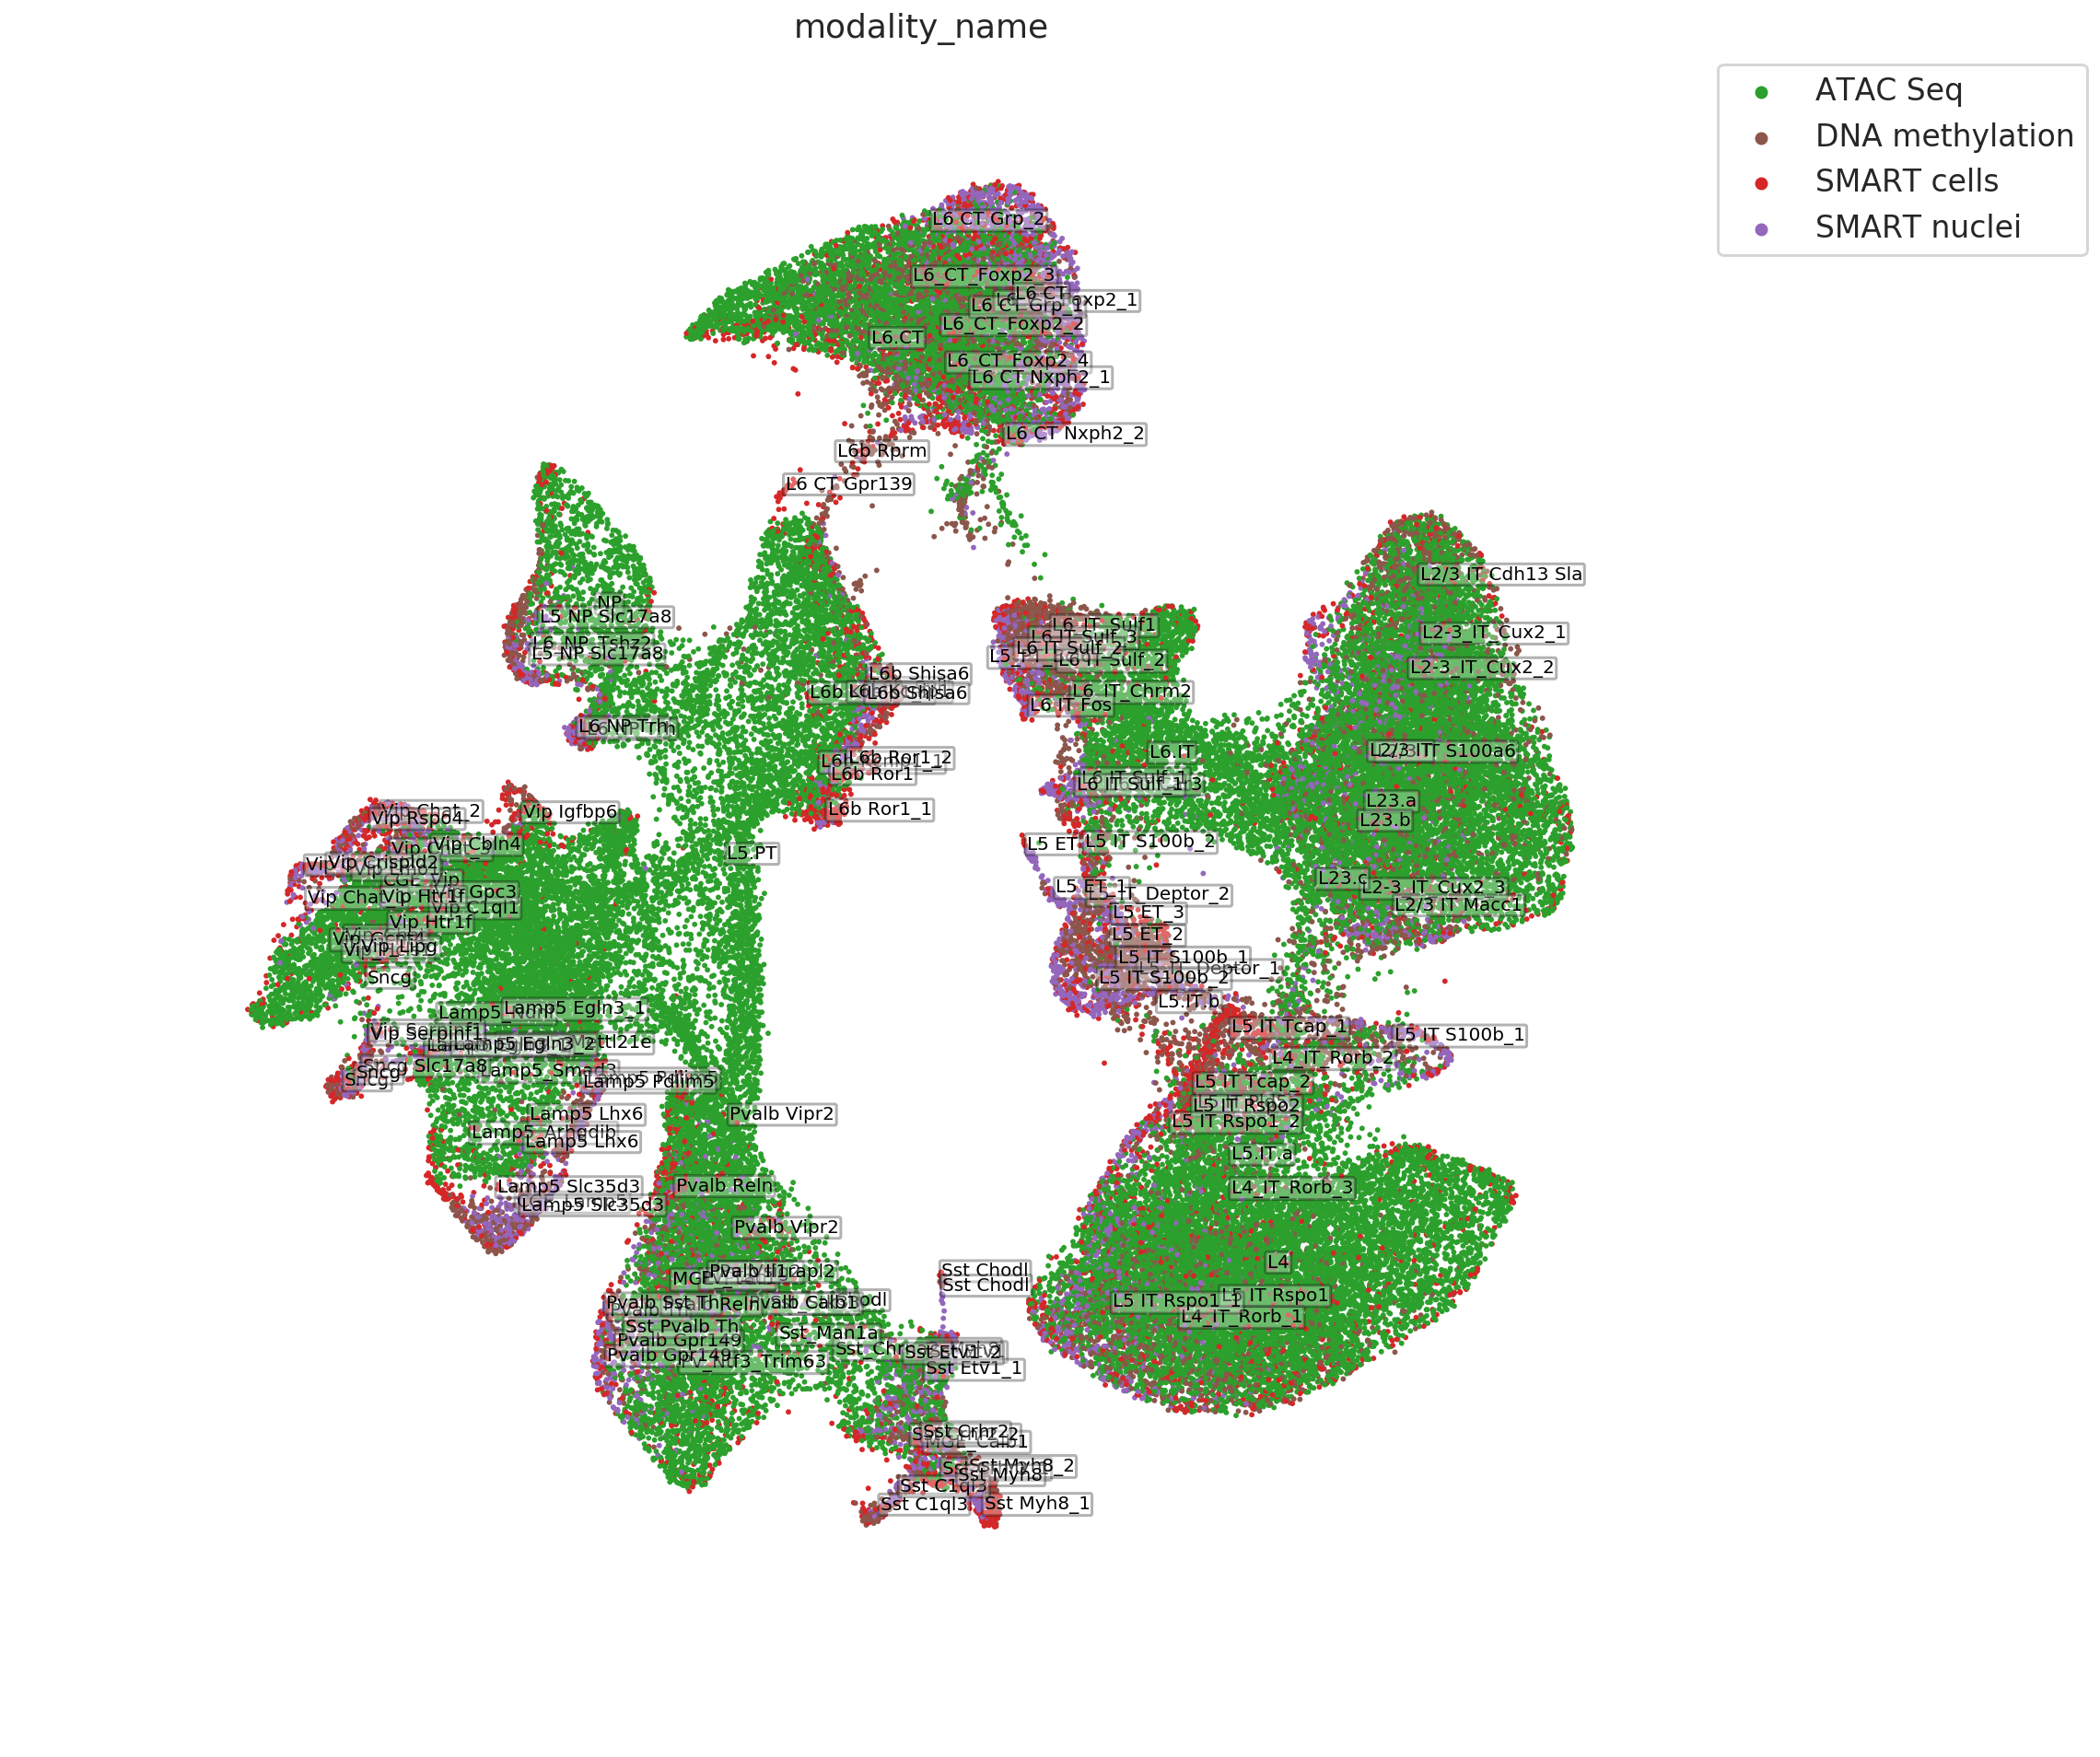

In [43]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, 1, figsize=(16*1,16*1))
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    
    # add labels
    for mod in mods_selected:
        for clst, centroid in centroids[mod].iterrows():
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    clst,
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=10,
                   )
    
    fig.savefig(output_figures.format(2, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

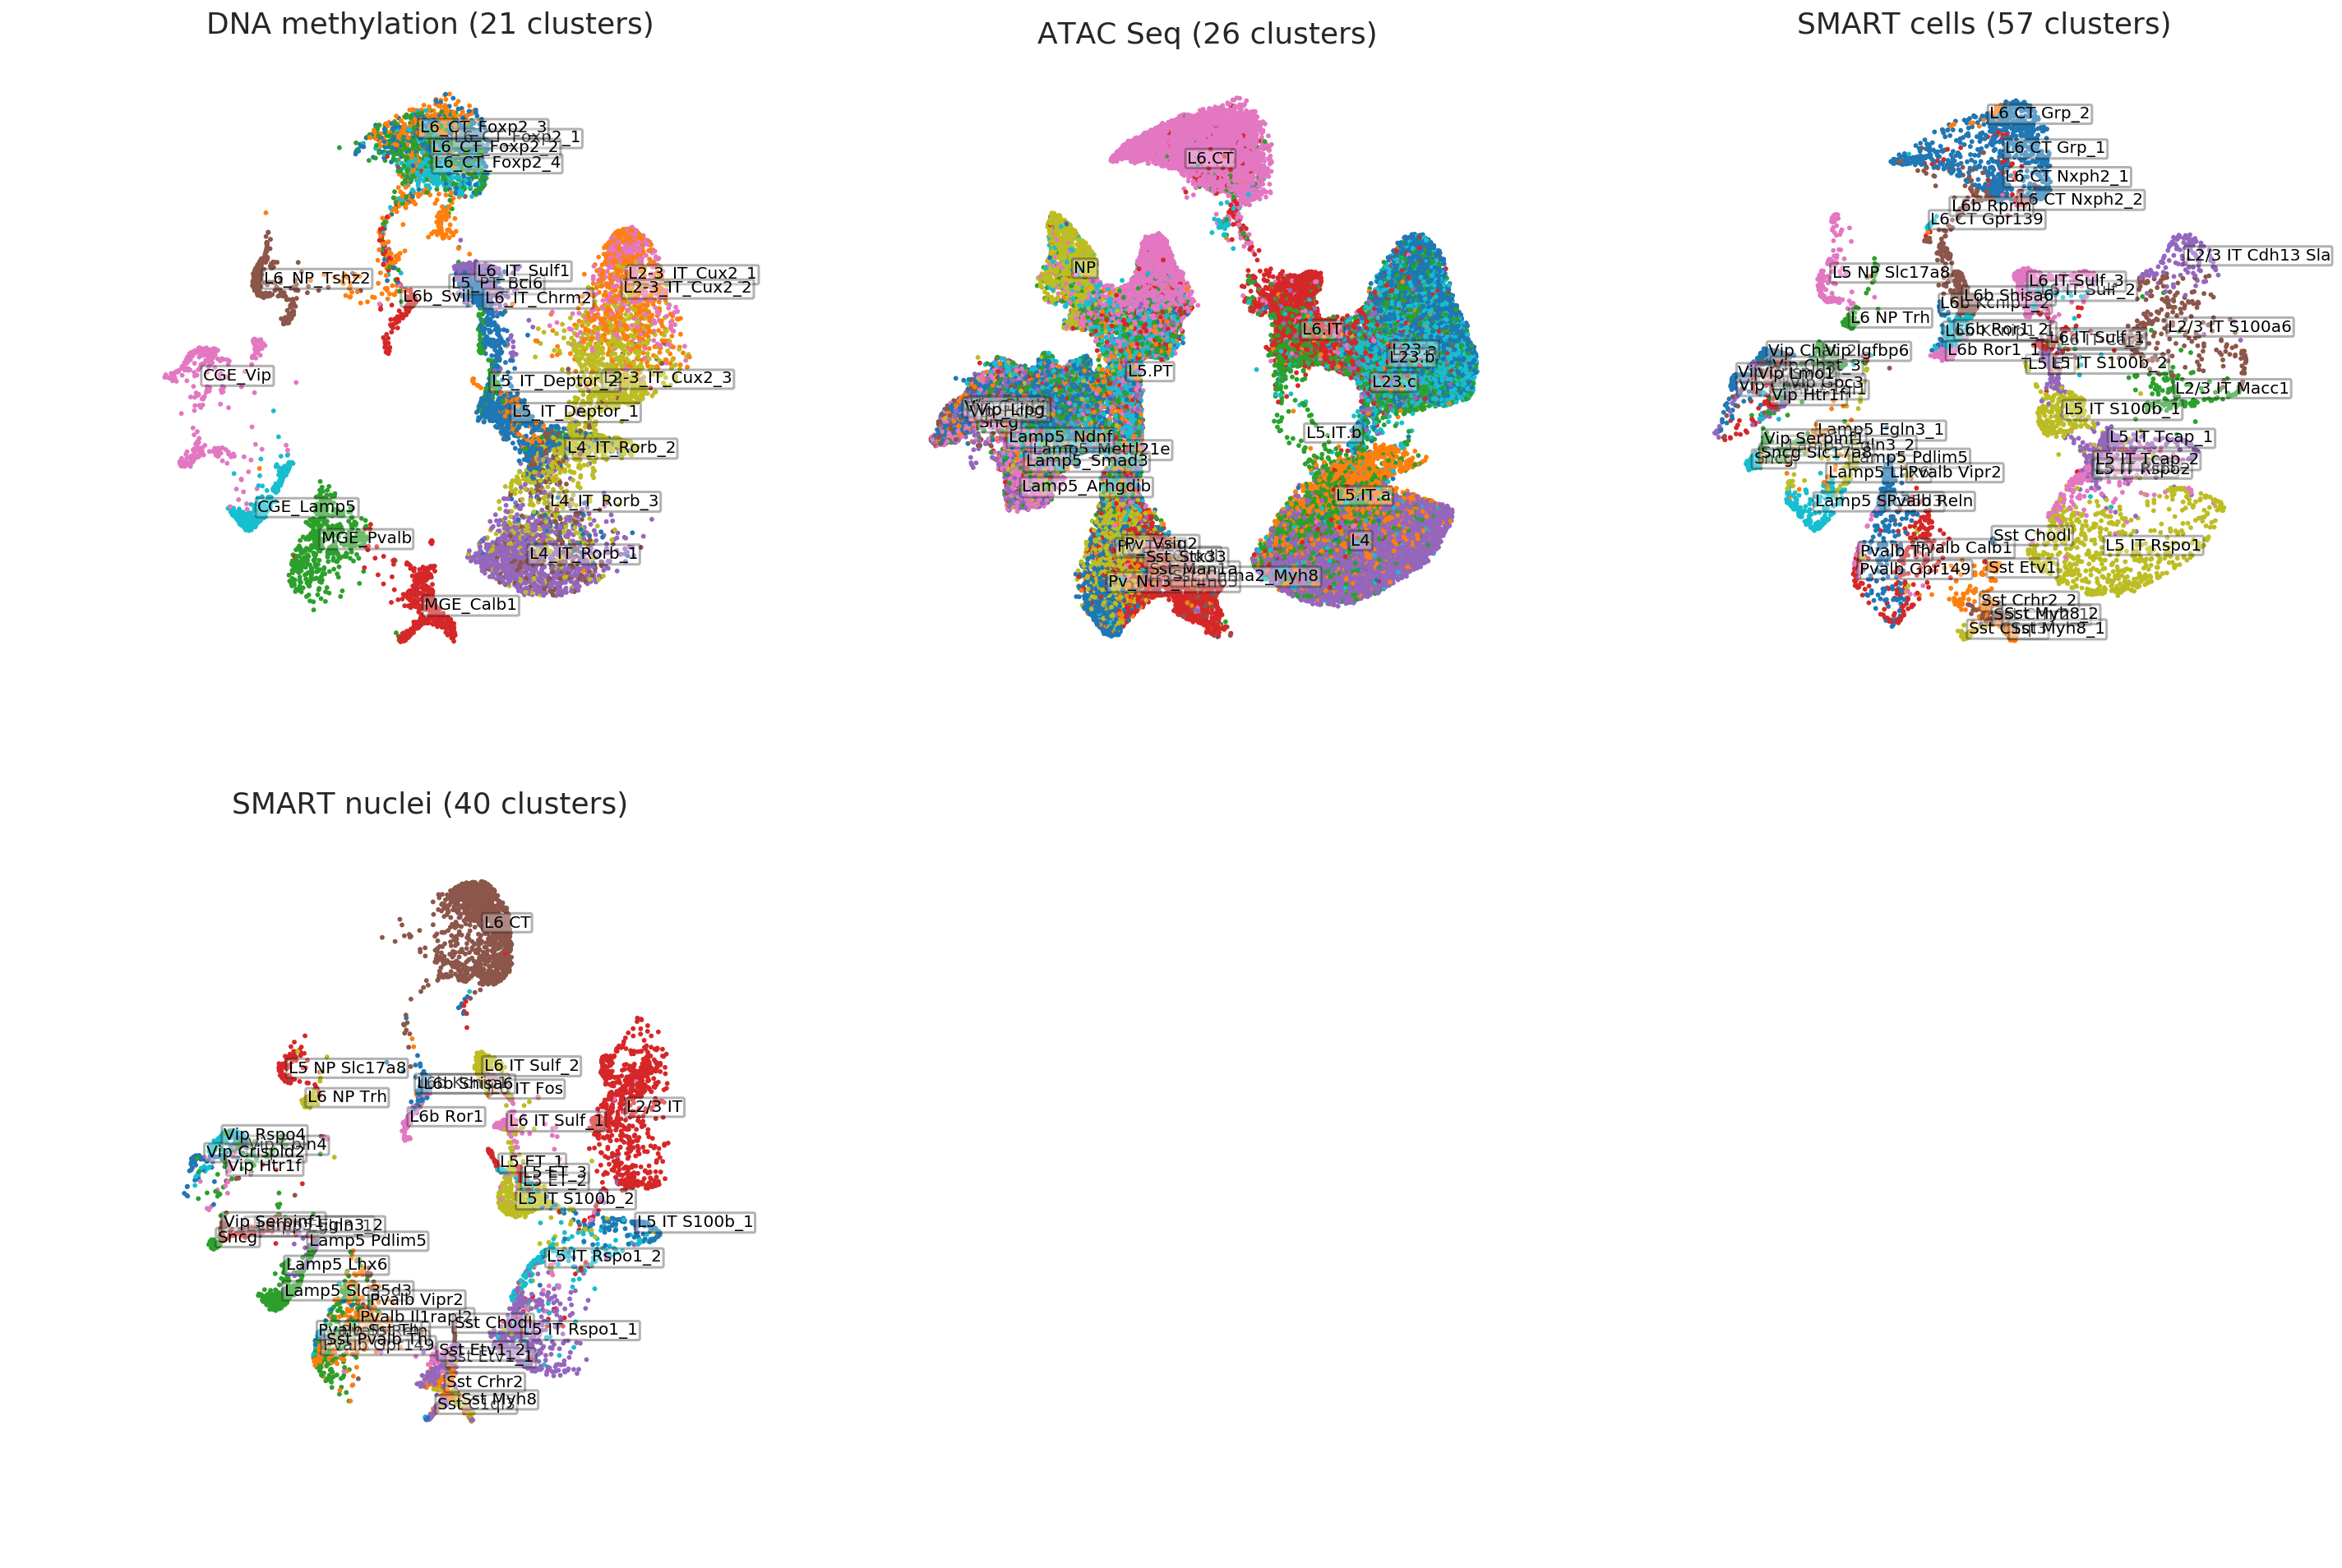

In [44]:
with sns.plotting_context('talk'):
    n = len(mods_selected)
    nx = 3
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(8*nx,8*ny))
    axs = axs.flatten()
    kw_colors = {mod: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'
#     legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    
    for ax, mod in zip(axs, mods_selected):
        snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
#                                           legend_kws=legend_kws,
                                          sample_n=sample_n,
                                          legend_mode=-1,
                                          rasterized=True,
#                                           kw_colors=kw_colors,
                                          s=2,
                                         )
        ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
                                          
        for clst, centroid in centroids[mod].iterrows():
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    clst,
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=10,
                   )
        ax.set_aspect('equal')
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')
        
    
    fig.savefig(output_figures.format(3, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

In [45]:
# Confusion matrix
# histograms

hist = df_info.groupby(['cluster_joint_r1', 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)

hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)
hist_enrich.head()

modality,smarter_cells,smarter_nuclei,snatac_gene,snmcseq_gene
cluster_joint_r1,,,,
1,0.418034,0.659568,1.109761,0.960510
2,1.289116,2.144758,0.735604,1.636501
3,0.640169,0.831020,1.055644,1.021373
4,0.967212,0.904897,1.087659,0.565445
5,0.600790,0.341682,1.263515,0.133724


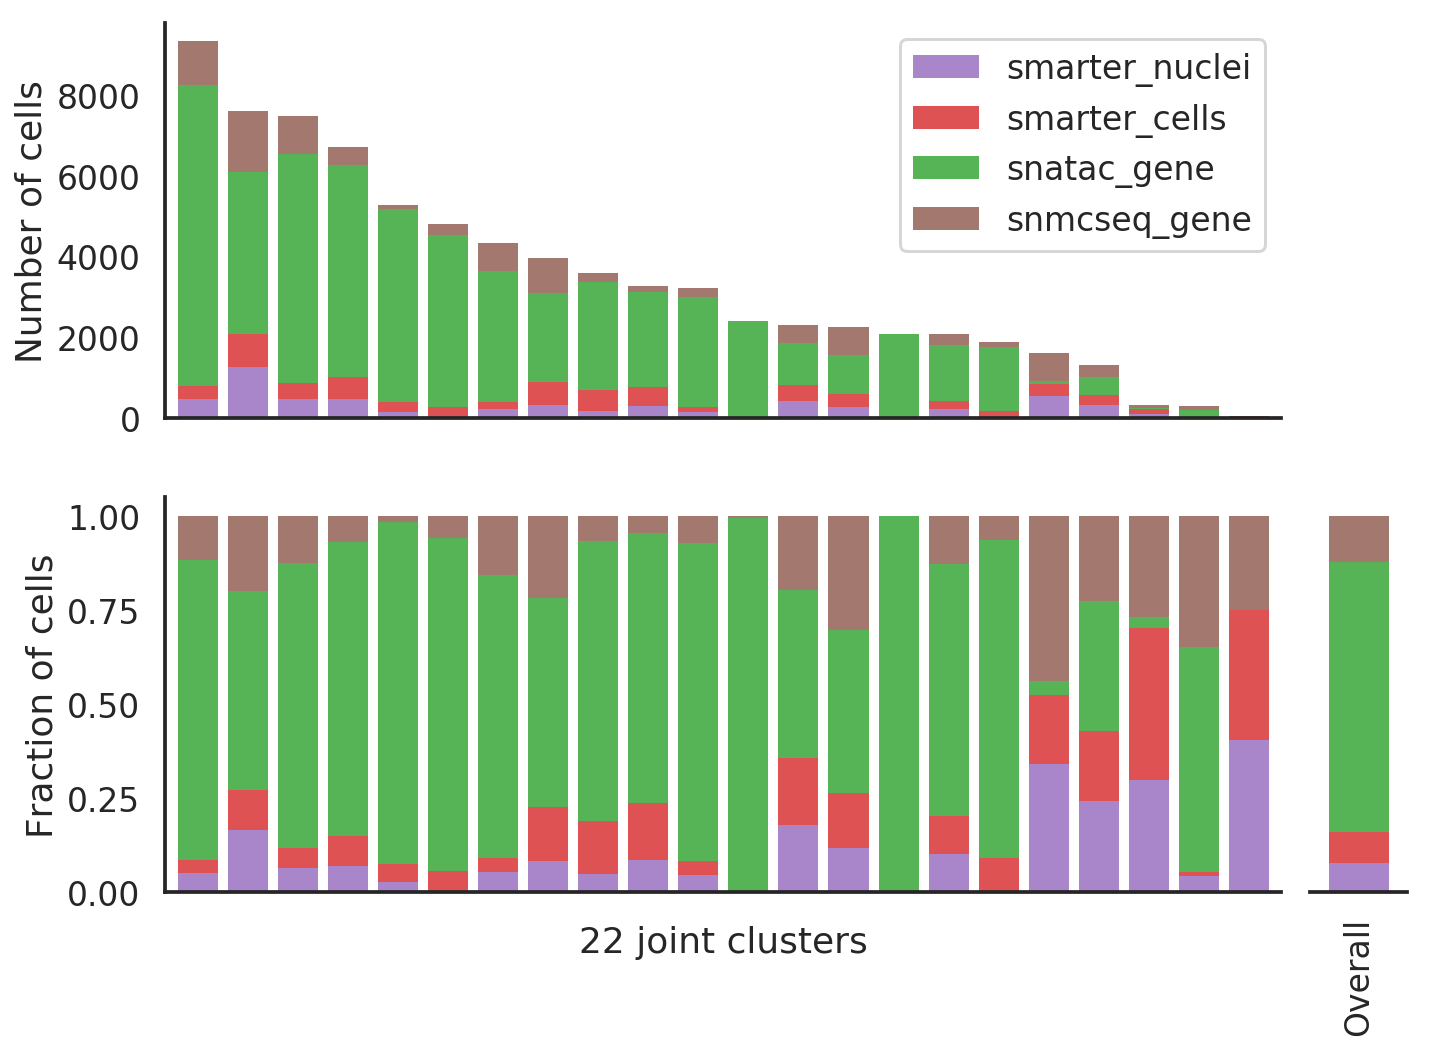

In [46]:
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_selected})

with sns.plotting_context('talk'), sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    # histograms
    fig, axs = plt.subplots(2, 1, figsize=(10,4*2))
    ax = axs[0]
    hist[mods_selected[::-1]].plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    

    ax = axs[1]
    hist_frac[mods_selected[::-1]].plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
    ax.set_xticklabels([])
    
#     ax = fig.add_axes([.95, .5, .05, .4])
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_selected[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                      .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                      color=[val for key, val in mod_colors.items()][::-1]) # this controls mod_colors
    )
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
#     fig.tight_layout()
    fig.savefig(output_figures.format(4, 'pdf'), bbox_inches='tight')
    plt.show()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


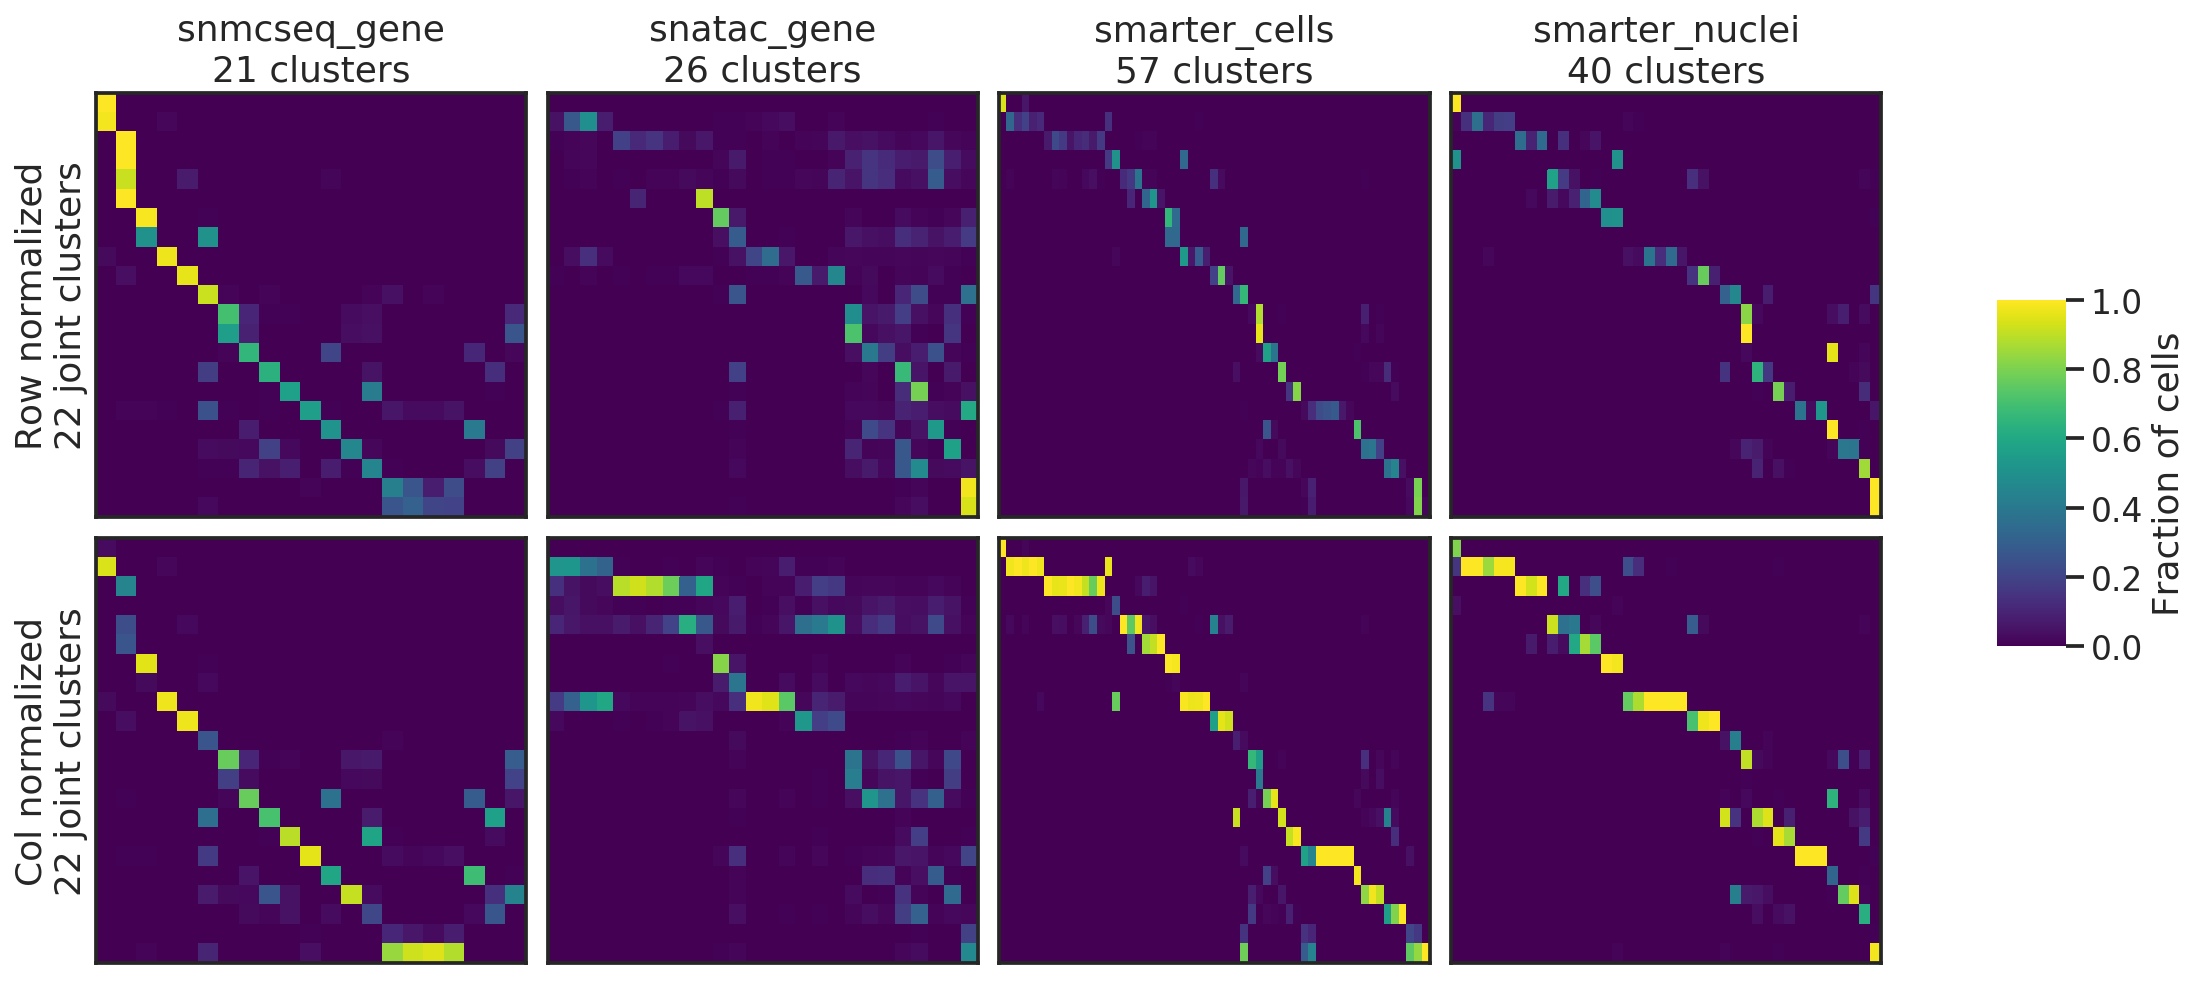

In [47]:
# confusion matrix

nx = len(mods_selected)
ny = 2
heatmap_kws = {
    'xticklabels': False, 
    'yticklabels': False,
    'vmin': 0, 
    'vmax': 1,
    'cmap': 'viridis',
}

cbar_kws = {
    'orientation': 'vertical', 
    'label': 'Fraction of cells',
}

with sns.plotting_context('talk'), sns.axes_style('white', {'patch.edgecolor': 'black'}):
    fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
    axs = axs.T
    cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
    njoint_clusters = len(df_info['cluster_joint_r1'].unique())
    for i, (mod, ax) in enumerate(zip(mods_selected, axs)):
        conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, 'cluster'], 
                               df_info.loc[df_info['modality']==mod, 'cluster_joint_r1'],
                              )
        # normalize each joint cluster
        conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
        # normalize each orig cluster
        conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

        # plot normalized by joint 
        if i == 0:
            # order both row and col
            _X = conf_mat_njoint
            _rX, ri, rc = snmcseq_utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, threshold=0.3)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=True,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
            g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)

            order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        else:
            # order just row (orig)
            _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=False,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
            g.axes.set_ylabel('')
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)

            order_orig = _rX.index.values # Will be fixed for the mod clusters  

        # plot normalized by orig (according to the axis of normalized by joint) 
        _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
        g = sns.heatmap(_X.T, 
                    cbar=False,
                    ax=ax[1],
                    **heatmap_kws,
                   )
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
        if i == 0:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
        else:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('')

        for _, spine in g.axes.spines.items():
            spine.set_visible(True)

    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format(5, 'pdf'), bbox_inches='tight')
    plt.show()